In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from d2l import torch as d2l


import numpy as np
from math import sqrt

import matplotlib.pyplot as plt

# Transformer Demystified -- Part 1 (Core Concepts and Encoder)

[Paul Golding](https://paulgolding.com/)


# Preface

This notebook is mostly an elaboration upon the explanation of Transformers given in Chapter 11 of Dive Into Deep Learning. If you want to run this notebook, you can see from above that you will need certain libraries. If this stuff is new to you, then follow the [installation guide of DIDL](https://d2l.ai/chapter_installation/index.html#chap-installation).

# Introduction

I seldom write technical explanations of things, ever since I stopped writing books when the age of everywhere-everything knowledge seemed to arrive via longform articles and various forums. What can I add to the plethora of materials from those with time to write and skilful things to say?

In this case, I found various explanations of Transformers to be lacking in crucial details, sometimes irritatingly so. There are quite a few annotations of papers/code without bringing crucial foundational knowledge to the fore, such as recognizing when researchers have probably made certain assumptions which they failed to explain because they got the results they wanted anyway.

So, perhaps rather foolishly, this is an attempt to explain Transformers right down to the lowest-level of key operations __whilst attempting to blend in some intuition with various nods to theory__, minus stringent mathematical exposition and jargon. The goal is not just explanation, but demystification. Very often, we encounter things that, whilst we understand (eventually) how they work, we aren't quite sure as to why they work or what made the inventors choose to include them in their approach.

Also, many things, especially in deep learning, can be explained via a variety of perspectives. Many researchers or commentators take a certain perspective based upon habit or learning, thereby adopting a set of terms of ideas that might not be so accessible to others coming from a different tradition. I attempt, here and there, to stitch together a few perspectives, e.g. from signal processing, engineering, linguistics, etc. Moreover, researchers often use technical terms in a non-technical sense, and vice-versa, which can confuse the unsuspecting reader.

I include attempts to probe into __some__ of the technical decisions in order to demystify them, noting that we can easily overlook how the output of a research paper is often the end product of lots of intermediate experiments that allowed the researchers to arrive at their conclusions -- i.e. whilst the technicalities of a paper can appear intimidating in their precision or decisiveness, we are not seeing all of the "workings out" that went into producing them via many experiments and edits of the paper. 

Moreover, as we shall see, some of the technical decisions perhaps don't make sense. This might well be legitimate, in the sense that many things in __Deep Learning (DL)__ work even though there often lacks a rigorous explanation as to why. This should give us hope when exploring our own ideas -- i.e. they might work, and hence why playing around is so important with your learning.

We have the tools these days (e.g. Pytorch and open source code) to experiment with almost luxurious ease, time-permitting.

To be clear, and not wanting to reinvent the wheel, I will attempt to blend the open-source materials from these two sources:

- https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html
- https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb

There are plenty of other good sources (e.g. the [Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)) but I selected these particular ones because they are part of wider learning programs wherein students who are following them might benefit from a more expanded explanation of the Transformer piece whilst providing a comparison of two approaches. Whilst they are broadly similar, they have some key differences (in implementation) that might confuse those performing comparisons. As the baseline, I more closely follow the D2L example because it ends up with a finished "from-scratch" Transformer model that can be trained on a small French-English dataset that the book authors include in their resources.

This notebook is a bit long, but I believe that diligently working through it will save you time versus trying to parse the original sources (where many details and intuitions are missed).


# Attention: Function, or Look-up Table?

First we consider the primary building block -- the attention function. In itself, it is just a method of computing relationships between a set of numerical samples wherein the set members presumably have non-random joint probabilities -- i.e. some kind of "relatedness". We expect this for language sampled from a text because word-order is required to impart meaning via syntactical rules, such as [subject-predicate](https://webapps.towson.edu/ows/sentelmt.htm) clauses. 

One thing to appreciate is that many inventions or ideas in technical work have been thought of before or arrived at via various thinkers from different perspectives. Hence, the starting point for self-attention that [Yann LeCun](http://yann.lecun.com/) favors is more related to an exposition of [differentiable associative memories](https://www.youtube.com/watch?v=AQtPoDnauq4&list=PLLHTzKZzVU9e6xUfG10TkTWApKSZCzuBI&index=19). One can think of the self-attention mechanism as a look-up table, or memory, whereby we can feed a set of tokens (word embeddings) as queries and look-up a bunch of values depending upon how the queries match with keys ("addresses") that point to the values.

Lest we forget, a look-up table can be used to "compute" any function -- after all, this is how log and trig tables work, for those who've seen such things.

Vitally, the design of the associative memory is differentiable, meaning that its "look-up" processes can be defined as a composite of functions wherein each function is differentiable. This look-up memory perspective is useful from a more generalized "thinking about deep learning" perspective, which we should always try to do. 

We could begin with the thought: what if we could use a look-up table in our networks? You might imagine all kinds of uses. In this case, the mechanism is used to input words from a set to "look-up" each other word and return values of "relatedness". Consider the set of words `{boy, street, man, into, the, ran}`. Now imagine this as an ordered set, namely a sentence:

- `The boy ran into the street`.

We can see that the word `boy` has some relationship with `ran`, but probably not so much with `street`.

So, consider a look-up table for this set into which we input the word `boy` and get back the most-related word -- i.e. `ran`. Or consider that it returns all words, but with scores that indicate relatedness. Hopefully, this concept is straightfoward, but why, then, do we need it to be differentiable and what might that mean?

In any DL context, differentiable is synonymous with trainable. Consider another sentence:

- `The street boy looked hungry.`

In this configuration, there is now a relationship between `boy` and `street`.

Our memory would be rather useless if it could not adapt (learn), otherwis it might only know how to relate subjects with predicates (in the first sentence) and not adjectives with nouns (in the second sentence).

We need a memory that can adapt so as to learn, for any particular set, how it should compute relatedness. This, in essence, is what the self-attention mechanism is all about.


We should first consider, in general, what sort of function -- irrespective of learning -- might allow us to measure the relaitionships between members of a set. This is the so-called "Attention" function. Its power comes slightly later when we figure out how to make this memory learn via a differentiable process.

Why would anyone think to use a differentiable memory in the first place? The answer is that in problems that need to observe samples that span a sequence, it seems obvious that in order to make decisions about any position in the sequence, we probably need to pay attention to what came before it. For those of you with an electronic engineering background, you might recognize this a a [finite state machine (FSM)](https://en.wikipedia.org/wiki/Finite-state_machine). However, unlike an FSM, the hope with Transformers is that we can avoid recurrent structures.

Without looking ahead to the so-called attention mechanism (next), electronic engineers familiar with digital signal processing might also appreciate that recurrent structures can often be replaced with parallel ones: [IIRs vs. FIRs](https://circuitglobe.com/difference-between-fir-filter-and-iir-filter.html#:~:text=The%20crucial%20difference%20between%20FIR,duration%20for%20a%20dynamic%20system.). The key point is that with text, at least when training, we already have all the samples "in parallel", so it seemed obvious that at some point someone would think to process them in parallel (within some reasonable limit of parallel processing efficiency gains). This is, in essence, what self-attention is all about.

## Scaled Dot-Product Attention

In consideration of the Attention function, the D2L book first emphasizes the need for a crucial sub-block called Masked Softmax. We will follow the same ordering (more or less) of component-level scrutiny so as to be consitent with the book's layout.

When computing with words in our network, there are efficiency gains from presenting all samples (at least within a given batch for processing) as if they are the same length, whether or not they are in reality. We do this by appending padding tokens to all sequences longer than some maximum (presumably the longest sentence, if we were presenting data one sentence at a time):

- `The boy ran into the street` -- length 6 words
- `The boy fell down` -- length 4 words, which becomes `The boy fell down [PAD] [PAD]` -- length 6 words

The output from our attention function, as mentinoed in the preamble, is going to be a set of scores that convey the relatedness of set members. These scores will have a numeric range (somewhat constrained by another normalizing process we shall mention later) and we want to treat them as probabilities, hence a softmax is applied to the scores. But we do not want the softmax to be skewed by the `[PAD]` tokens, so we mask them out, per the function below.

Note that this function expects an mask `valid_len` which is the valid length of the set, which in the case of the first sentence is `6` (we want to measure all 6 tokens) and in the case of the second sentence is `4` -- we only want to softmax across the first 4 outputs from the function.

In [2]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
# batchsize, samples, dimensions
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2,3]))

tensor([[[0.6063, 0.3937, 0.0000, 0.0000],
         [0.5708, 0.4292, 0.0000, 0.0000]],

        [[0.2747, 0.2915, 0.4338, 0.0000],
         [0.2871, 0.2824, 0.4305, 0.0000]]])

Note that this softmax gets applied to the output of the scaled dot-product:

![](https://raw.githubusercontent.com/nlp-with-transformers/notebooks/5dce9357463435c7208bf5e1a4cc5be6e49e0a40//images/chapter03_attention-ops.png)

Let's look at a simplified version of the scaled dot product before we apply masking.

In [4]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

From the outset, let's assume we have an embedding matrix to give us our embeddings:

In [5]:
vocab_size = 30522 #per Bert words
embedding_dim = 768 # per "bert-base-uncased"
inp_embeds = nn.Embedding(vocab_size, embedding_dim)

# some text, but let's use a real tokenizer
from transformers import AutoTokenizer
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [6]:
sentence_1 = 'Hello world' # 2 tokens, batch 1
sentence_2 = 'The cat sat on a mat' # 6 tokens batch 1
sentence_3 = 'The man ran fast' # 4 tokens, batch 2
sentence_4 = 'Save the world' # 3 tokens, batch 2

Note that we are using tidy sentences. In reality, during training, these are actually chunks of text which may or may not coincide with actual sentence boundaries.

In [7]:
# let's tokenize and add padding
s_1 = tokenizer(sentence_1, return_tensors="pt", add_special_tokens=False, padding=True, pad_to_multiple_of=6)
s_2 = tokenizer(sentence_2, return_tensors="pt", add_special_tokens=False, padding=True, pad_to_multiple_of=6)
s_3 = tokenizer(sentence_3, return_tensors="pt", add_special_tokens=False, padding=True, pad_to_multiple_of=6)
s_4 = tokenizer(sentence_4, return_tensors="pt", add_special_tokens=False, padding=True, pad_to_multiple_of=6)


In [8]:
# make 2 batchs of 2 sentences per batch
b1 = torch.vstack((s_1.input_ids,s_2.input_ids)).reshape(1,2,6)
b2 = torch.vstack((s_3.input_ids,s_4.input_ids)).reshape(1,2,6)

In [9]:
words = torch.cat((b1,b2)).reshape(2,2,6)
words

tensor([[[ 7592,  2088,     0,     0,     0,     0],
         [ 1996,  4937,  2938,  2006,  1037, 13523]],

        [[ 1996,  2158,  2743,  3435,     0,     0],
         [ 3828,  1996,  2088,     0,     0,     0]]])

Note the padding 0s here.

In [10]:
# let's encode words into the embedding space
# here we use a randomly initialized embedding layer, but it will either be trained or pre-trained in practice
X = inp_embeds(words)
X.shape

torch.Size([2, 2, 6, 768])

This is now what we expect as resembling an input set.

`batch idx, batch size, seq length, embedding dimension`

In [11]:
# take just the first batch X[0] of embedded sentences
print(X[0].shape)
queries = X[0]
keys = X[0]
values = X[0]

# now let's feed them into our scaled dot product function
sdp = scaled_dot_product_attention(queries, keys, values)
print(sdp.shape)

torch.Size([2, 6, 768])
torch.Size([2, 6, 768])


So we get out a tensor with the same shape as the input.

But what is it?

What has happened?

Let's first apply the masked softmax and confirm that the size of the output is still the same.


In [12]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, num_heads=None):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads  # To be covered later

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None,
                window_mask=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / sqrt(d)
        if window_mask is not None:  # To be covered later
            num_windows = window_mask.shape[0]
            n, num_queries, num_kv_pairs = scores.shape
            # Shape of window_mask: (num_windows, no. of queries,
            # no. of key-value pairs)
            scores = scores.reshape((n // (num_windows * self.num_heads), num_windows, self.
    num_heads, num_queries, num_kv_pairs)) + window_mask.unsqueeze(1).unsqueeze(0)
            scores = scores.reshape((n, num_queries, num_kv_pairs))
        print(f'scores.shape: {scores.shape}')
        self.attention_weights = masked_softmax(scores, valid_lens)
        print(f'attention_weights.shape: {self.attention_weights.shape}')
        return torch.bmm(self.dropout(self.attention_weights), values)

In [13]:
print(queries.shape)
dpa = DotProductAttention(dropout=0)

# we tell the function that the masks for each sequence are 2 and 6, per our original padding
dpa(queries, keys, values, valid_lens=torch.tensor([2,6]))

torch.Size([2, 6, 768])
scores.shape: torch.Size([2, 6, 6])
attention_weights.shape: torch.Size([2, 6, 6])


tensor([[[-0.9501, -0.6574,  2.3066,  ...,  1.8316,  0.1731, -0.8814],
         [ 0.6225,  0.2483,  1.1284,  ..., -2.2712, -0.9497,  0.6449],
         [-0.0176, -0.1203,  1.6080,  ..., -0.6013, -0.4927,  0.0236],
         [-0.0176, -0.1203,  1.6080,  ..., -0.6013, -0.4927,  0.0236],
         [-0.0176, -0.1203,  1.6080,  ..., -0.6013, -0.4927,  0.0236],
         [-0.0176, -0.1203,  1.6080,  ..., -0.6013, -0.4927,  0.0236]],

        [[ 1.0517,  0.3274, -1.1777,  ..., -0.5956, -2.0830,  0.7717],
         [-2.2429, -1.3659, -0.5961,  ..., -0.7291,  1.1059, -0.3884],
         [ 0.7007, -0.7129,  0.3732,  ...,  1.1684, -1.4170, -0.6048],
         [ 0.7611,  0.5534,  1.5125,  ..., -0.9154,  1.2436, -1.3114],
         [-0.6299,  0.7023,  0.5553,  ...,  0.4764, -0.5027,  0.7116],
         [ 0.7832,  0.3657, -0.2309,  ...,  1.1546, -0.8599, -0.5334]]],
       grad_fn=<BmmBackward0>)

In [14]:
# now let's scrutinize the core operations to see what's happening.
# work backwards from the bmm - batch matrix multiplication
torch.bmm(queries, keys.transpose(1,2))

tensor([[[783.1001,   2.1246,  -1.4681,  -1.4681,  -1.4681,  -1.4681],
         [  2.1246, 759.7991,   8.9597,   8.9597,   8.9597,   8.9597],
         [ -1.4681,   8.9597, 756.6523, 756.6523, 756.6523, 756.6523],
         [ -1.4681,   8.9597, 756.6523, 756.6523, 756.6523, 756.6523],
         [ -1.4681,   8.9597, 756.6523, 756.6523, 756.6523, 756.6523],
         [ -1.4681,   8.9597, 756.6523, 756.6523, 756.6523, 756.6523]],

        [[830.9068,  12.4187,  15.8432, -25.1519,  11.8749, -18.3366],
         [ 12.4187, 817.0351,   5.1903,  59.2775,   5.1025, -22.6555],
         [ 15.8432,   5.1903, 811.6682,   3.1711, -32.8211,  15.7357],
         [-25.1519,  59.2775,   3.1711, 730.3518, -11.7135, -30.0732],
         [ 11.8749,   5.1025, -32.8211, -11.7135, 783.6600,  23.7532],
         [-18.3366, -22.6555,  15.7357, -30.0732,  23.7532, 733.6476]]],
       grad_fn=<BmmBackward0>)

Let's simplify with a toy example to see what's going on.

In [15]:
qu = torch.ones((2,2,4))/2
qu

tensor([[[0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000]]])

In [16]:
k = qu.transpose(1,2)
k

tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]]])

In [17]:
torch.bmm(qu,k)

tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])

BMM is how we do the batch-wise dot product.

In the case of our toy example, for a single batch we have two queries:

- `q_0 = [0.5, 0.5, 0.5, 0.5]`
- `q_1 = [0.5, 0.5, 0.5, 0.5]`

And two keys:

- `k_0 = [0.5, 0.5, 0.5, 0.5]`
- `k_1 = [0.5, 0.5, 0.5, 0.5]`

We end up with, for a single batch:

` [[ q_0@k_0, q_0@k_1], [q_1@k_0, q_1@k_1]]`

In the case of our original example where the batch is `[2, 6, 768]`

Queries:
- `q_0 = [q_0(0) ... q_0(767)]`
- `...`
- `q_5 = [q_5(0) ... q_5(767)]`

Keys:

- `k_0 = [k_0(0) ... k_0(767)]`
- `...`
- `k_5 = [k_5(0) ... k_5(767)]`

So, a single batch dot product is `[1, 6, 6]`:

```
[[ q_0@k_0, q_0@k_1, q_0@k_2, q_0@k_3, q_0@k_4, q_0@k_4 ],
 [ q_1@k_0, q_1@k_1, q_1@k_2, q_1@k_3, q_1@k_4, q_1@k_4 ],
 [ q_2@k_0, q_2@k_1, q_2@k_2, q_2@k_3, q_2@k_4, q_2@k_4 ],
 [ q_3@k_0, q_3@k_1, q_3@k_2, q_3@k_3, q_3@k_4, q_3@k_4 ],
 [ q_4@k_0, q_4@k_1, q_4@k_2, q_4@k_3, q_4@k_4, q_4@k_4 ],
 [ q_5@k_0, q_5@k_1, q_5@k_2, q_5@k_3, q_5@k_4, q_5@k_4 ]]
```

But there are 2 batches, so the final `bmm` output dimension should be `[2,6,6]`

This process is giving us the attention function for merging keys with queries, per the diagram:

![](https://d2l.ai/_images/attention-output.svg)

Note that we don't yet have any learnable way of applying this function -- we are using the queries and keys as-is -- but adding in a learnable element will come later.

In [18]:
batch1_bmm = torch.bmm(queries, keys.transpose(1,2))
batch1_bmm.shape

torch.Size([2, 6, 6])

Now we can see that the number of outputs per batch corresponds to the number of inputs (i.e. queries) -- i.e. 6 vectors, but each with 6 values that correspond with the dot products with each key.

Each of these `6x6` matrices is what?

Each entry is how each element of the set (i.e. each word) "aligns" (dot-product) with each other word.

As we might expect, this isn't very useful at this stage because we have not done anything to make the dot-products more expressive based upon sentence syntax and meaning. It's just a crude dot-product, or a kind of cross-correlation of each word with each other. As such, as you might expect, the highest score in each vectors is going to be the word (query) with itself (key) (assuming each word is unique in the set). Let's check...

In [19]:
# which values in each attention vector are the highest?
torch.argmax(batch1_bmm[1], dim=1)

tensor([0, 1, 2, 3, 4, 5])

The softmax is applied across this  -- i.e. converts each query-key dot product to a softmax distribution.

In [20]:
d = queries.shape[-1]
print(f'hidden/embedded dim = {d}')
scores = torch.bmm(queries, keys.transpose(1,2)) / sqrt(d)
F.softmax(scores, dim=-1)

hidden/embedded dim = 768


tensor([[[1.0000e+00, 5.7695e-13, 5.0680e-13, 5.0680e-13, 5.0680e-13,
          5.0680e-13],
         [1.3375e-12, 1.0000e+00, 1.7116e-12, 1.7116e-12, 1.7116e-12,
          1.7116e-12],
         [3.2904e-13, 4.7936e-13, 2.5000e-01, 2.5000e-01, 2.5000e-01,
          2.5000e-01],
         [3.2904e-13, 4.7936e-13, 2.5000e-01, 2.5000e-01, 2.5000e-01,
          2.5000e-01],
         [3.2904e-13, 4.7936e-13, 2.5000e-01, 2.5000e-01, 2.5000e-01,
          2.5000e-01],
         [3.2904e-13, 4.7936e-13, 2.5000e-01, 2.5000e-01, 2.5000e-01,
          2.5000e-01]],

        [[1.0000e+00, 1.4903e-13, 1.6863e-13, 3.8414e-14, 1.4613e-13,
          4.9124e-14],
         [2.4584e-13, 1.0000e+00, 1.8940e-13, 1.3335e-12, 1.8880e-13,
          6.9342e-14],
         [3.3762e-13, 2.2987e-13, 1.0000e+00, 2.1372e-13, 5.8317e-14,
          3.3631e-13],
         [1.4465e-12, 3.0439e-11, 4.0195e-12, 1.0000e+00, 2.3491e-12,
          1.2111e-12],
         [8.0382e-13, 6.2955e-13, 1.6022e-13, 3.4316e-13, 1.0000e+00

In [21]:
# but recall our original X before embedding
torch.cat((b1,b2)).reshape(2,2,6)

tensor([[[ 7592,  2088,     0,     0,     0,     0],
         [ 1996,  4937,  2938,  2006,  1037, 13523]],

        [[ 1996,  2158,  2743,  3435,     0,     0],
         [ 3828,  1996,  2088,     0,     0,     0]]])

We can see here that the `0` entries are present, which are our padding codes. These need to be masked out to ignore them from the score.

We are only dealing here with the first batch of:

- batch size = 2
- sequence size = 6
- embedding dim = 768

In [22]:
masked_softmax(scores, valid_lens=torch.tensor([2,6]))

tensor([[[1.0000e+00, 5.7695e-13, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.3375e-12, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.0702e-01, 5.9298e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.0702e-01, 5.9298e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.0702e-01, 5.9298e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.0702e-01, 5.9298e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]],

        [[1.0000e+00, 1.4903e-13, 1.6863e-13, 3.8414e-14, 1.4613e-13,
          4.9124e-14],
         [2.4584e-13, 1.0000e+00, 1.8940e-13, 1.3335e-12, 1.8880e-13,
          6.9342e-14],
         [3.3762e-13, 2.2987e-13, 1.0000e+00, 2.1372e-13, 5.8317e-14,
          3.3631e-13],
         [1.4465e-12, 3.0439e-11, 4.0195e-12, 1.0000e+00, 2.3491e-12,
          1.2111e-12],
         [8.0382e-13, 6.2955e-13, 1.6022e-13, 3.4316e-13, 1.0000e+00

## About Masking


The dot-product of two vectors is a scalar, so the dimensions of the attention vector `(Q@K.T)` are going to always be a `[q_dim * k_dim]` -- e.g. if we have 6 queries, then we end up with `[6x6]`

(Note that wherever we write `q/k/v_dim` we mean the number of elements in those sets -- e.g. 6 keys is `k_dim = 6`.)

Query matrix = `[q_dim * d]` 
Key matrix = `[k_dim * d]`

For dot product: `[q_dim, d] * [d, k_dim]` -- i.e. we transpose Keys

Which gives us `[q_dim, k_dim]`

In practice, this ends up as `[q_dim, q_dim]` because we have same number of queries as keys.

Given the `k_dim` constraint, then our mask length spans `k_dim` for each batch.

So, for masked scaled dot product, the `valid_lens` argument should not exceed `k_dim` for any batch or sample. Note that in the above implementation, it doesn't matter if it does exceed `k_dim` because of the line of code:

`mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]`

This generates a mask of booleans for each of the size(1) dimensions of `valid_lens` -- e.g. if it's `[1,4]` then there are two values, so casting `[:,None]` gives us `[[1],[4]]` and then taking the arange of length `maxlen`, we set all values less than the corresponding len (e.g. `<1` for the first row and `<4` for the second) to give us something like:

```
tensor([[ True, False, False, False, False, False],
        [ True,  True,  True,  True, False, False]])
```

We the use this to mask the input samples with `value=0` wherever we have `False` entries -- `X[~mask] = value`

In practice, we might want to catch a `valid_len > maxlen` condition as an error to alert the client code that is it probably doing something wrong, but that depends upon implementation details.

NOTE: At this point, our masking is only concerned with how we remove padding from our softmax calculation. This is not the masking we consider for the decoder when trying to train our network -- we will explore this later.

## Attention

So all we have implemented thus far is the scaled dot product and included a masking process that will allow us to use this function in practice -- i.e. when we have variable length sequences that required padding to create a batch of equally sized queries.

We take our masked scaled dot product `Q@k.T/d**0.5` and save this as `attention_weights`

Then we apply `torch.bmm(self.dropout(self.attention_weights), values)`

Consider a single sample from the batch, which will be `[v_dim, d]` and we have a set of attention vectors `[k_dim, k_dim]` wherein `v_dim = k_dim` because they are the same vectors (for self attention). In our example above, `k_dim` was 6 (our sequence length) and so our attention weights are `[6,6]`.

Now we want to apply these weights to the values, so we batch multiply, which has the dimensions: `[v_dim, v_dim] * [v_dim, d]` which will give us a resultant `[v_dim, d]` matrix -- i.e. we are back to a set of outputs with the same dimensions as the inputs. These are our scaled attention vectors.

To follow it through, consider a single query. 

We have our set of weighted keys normalized via softmax: `[[w_0], [w_1], [w_2], [w_3], [w_4], [w_5]]` where in our example, each `w_i` is `[1,6]` (or `[1, sequence_length]` more generally).

In the function, these are called scores:

In [23]:
scores = torch.bmm(queries, keys.transpose(1, 2)) / sqrt(d)
print(f'shape of the scores is: {scores.shape}')

# let's look at a single score in sentence_2 for the word "The" from "The cat sat on a mat":
print(scores[1][0])

shape of the scores is: torch.Size([2, 6, 6])
tensor([29.9828,  0.4481,  0.5717, -0.9076,  0.4285, -0.6617],
       grad_fn=<SelectBackward0>)


And we have our values: `[[v_0], [v_1], [v_2], [v_3], [v_4], [v_5]]` (each of length `d`). 

In [24]:
values[1].shape

torch.Size([6, 768])

Via the `bmm` operation, we end up with:

`[w_0]*[v_0] + [w_1]*[v_1] + [w_2]*[v_2] + [w_3]*[v_3] + [w_4]*[v_4] + [w_5]*[v_5]` 

-- i.e. the weighted sum of the values (of dimension `d`).

In [25]:
# here's the first word "The" via its attention score multiplied with the key to get the final output for position 0
torch.matmul(scores[1][0], values[1]).shape

torch.Size([768])

Note that all members of the sequence get attention with every other member -- i.e. a kind of many-to-many arrangement.

Consider an artificial case where the query perfectly aligned with one of the keys to produce a softmax output that is more or less [1, 0, 0, 0, 0, 0] -- i.e. the scaled dot product is saying to attend to the first key ("0th key") for this query. The output will thus be the first value and nothing else -- i.e. it will be the query itself in the self-attention case.

Of course, this scenario cannot happen with what we have constructed thus far, but you get the idea.

Now, remember that we are not dealing with any old vectors. We are dealing with word/token embeddings where the dot product between embeddings has some kind of computational meaning, as in word similarity or semantic relatedness (in the embedding space). This is a key part of why this approach might bootstrap the learning of the weights (which we will see next) that determine the actual self-attendance of tokens in the sequence.

As a final note in consideration of what we have discussed thus far, consider the computational complexity. The scaled dot-product involves a matrix multiplication with dimensions: `[q_dim, d] * [d, k_dim]`. Afterwards, the matrix product is multiplied by another matrix `[v_dim, v_dim] * [v_dim, d]`. Considering the number of multiplications, they scale with the sequence length quadratically -- i.e. `q_dim**2` because we have to compare (multiply) each input token with every other one.

But note that the attention function can be completely parallel, requiring no iterative operations (unlike an RNN).

If you want to see the math of this laid out symbolically, see [this blog post](https://kikaben.com/transformers-self-attention/)

In [26]:
final_attention_vectors = dpa(queries, keys, values, valid_lens=torch.tensor([2,6]))
print(final_attention_vectors.shape)

scores.shape: torch.Size([2, 6, 6])
attention_weights.shape: torch.Size([2, 6, 6])
torch.Size([2, 6, 768])


__Note:__ it is important to realize that the attention operation is invariant to the embedding dimension `d`. Note that we did not declare this dimension in our function. Indeed, the scaled dot product attention operator is purely functional -- it has no storage or layers. Hence we can feed in any width of data:

In [27]:
# toy example to show how changing the dimension d or the seq length makes no difference 
# -- the function is invariant to these dimensions and functionally executes the sequence in parallel
seq_len = 5; e_dim = 10
new_queries = torch.randn((2, seq_len, e_dim)) # 2 text blocks (in batch) of seq_len long, each token e_dim width

# feed into the same dpa instance already declared (i.e. no need to redeclare it for different dimensions)
print(f'dot-product attn:{dpa(new_queries, new_queries, new_queries, None).shape}')
print(' ')

# change the sequence length and embedding dimension -- it doesn't matter
seq_len = 3; e_dim = 12
new_queries = torch.randn((3, seq_len, e_dim)) # 3 text blocks (in batch) of seq_len long, each token e_dim width
print(f'dot-product attn:{dpa(new_queries, new_queries, new_queries, None).shape}')


scores.shape: torch.Size([2, 5, 5])
attention_weights.shape: torch.Size([2, 5, 5])
dot-product attn:torch.Size([2, 5, 10])
 
scores.shape: torch.Size([3, 3, 3])
attention_weights.shape: torch.Size([3, 3, 3])
dot-product attn:torch.Size([3, 3, 12])


As we can see, changing the sequence length is merely scaling the dimension of the inner product -- making it longer or shorter (number of multiplies and additions), per the rules of matrix multiplication `[q_dim, d] * [d, k_dim]`. The only thing changing is the level of complexity, which is scaling quadratically with the sequence length.

Whilst changing the dimension of the embedding width is merely scaling the operands in the final weighted-sum operation involving the softmax output and the values: `[v_dim, v_dim] * [v_dim, d]` which will give us a resultant `[v_dim, d]` matrix.

This will become more important to understand later when we trucate the attention operation to use an inner dimension `r` that is less than the dimension `d` of the original keys, queries and values. 

# Multi-Head Attention (MHA)

Per https://d2l.ai/chapter_attention-mechanisms-and-transformers/multihead-attention.html

We now consider a learnable system, as in a differentiable associated memory whereby the "weighted-sum" process of attention is subject to linear transformations via fully connected layers that can transform the keys, queries and values in ways that make the attention function useful for language operations.

Thus far, our computations are "vanilla" -- we are doing dot products wherein the values have no correspondence with word relationships -- they are just the arbitrary values of dot-products between word embeddings.

What happens if we insert linear layers between the keys, queries, values and the attention function. If we do this, we have a trainable system. Depending upon the loss function, we can backprop our attention vectors through the attention network to see if we can get the attention mechanism to make sense of the sets -- i.e. for `street` and `boy` to have related meaning in the sentence `The street boy was hungry` and for `boy` and `ran` to "pay attention" to each other in the sentence `The boy ran into the street`, probably not paying any attention to `street` in this sentence.

This is the idea behind the network element in the diagram below:

![](https://d2l.ai/_images/multi-head-attention.svg)

## Motivation - Word Patterns

Why should we do this? Let's dwell for a moment on forming our intuitions so that the operation of the MHA makes more sense.

We understand that words can map to dense embeddings -- e.g. [see lecture](https://www.cs.princeton.edu/courses/archive/fall16/cos402/lectures/402-lec10.pdf)

To build a language model, we want to compute conditional probabilities related to sequences of tokens. A good example is per the [book](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb) in consideration of two sentences:

- `Time *flies* like an arrow`
- `Fruit *flies* like a banana`

The probability that the word `flies` belongs in each sequence is conditional upon the context. Here we consider context to mean the other words in the sentence. But context could be even wider. For example, consider the wider context:

- `There are many metaphors for thinking about time. For example: time *___* like an arrow.` __(Context A)__
- `Insects are often attracted to fruit. For example, fruit *___* like a banana` __(Context B)__

There are both syntactial probabilities and semantic ones. Syntatically speaking, `P(___=='robot' | Context A)` is very small indeed because the bi-gram `time robot` is probably very low within the corpus (assuming it's an unusual phrase, although not implausible -- e.g. could be a sci-fi object). Or, consider that `P(___=='dog' | Context B)` is probably very likely to be quite low given that it is syntactially incorrect.

But how might we compute that `flies` is a likely candidate in either context?

In __Context A__ we can see (from human understanding) that there is some kind of connection with the word `arrow` because of the conjunction `like an`. We therefore mentally skew our attention towards `arrow` in deciding likely candidates for the blank.

Imagine we can train our network to see many examples of the pattern `X is like a Y`. Then we could imagine skewing our weighted-sum (scaled dot product attention function) to "pull" the candidate word towards the subject (`arrow`). In other words (forgive the pun) we want to find a word embedding vector that algebraically connects `___` to `arrow`. Of course, that algebraic formula is some complex ("blackbox") set of projections to get us there, aided by the vectors from the rest of the context.

In this sense, we can think of training one attention function to learn the pattern `X is like a Y` in its simile sense and to apply this to our inputs to see what candidate words emerge to complete our sequence as a simile. Furthermore, perhaps the presence of the word `metaphors` and `time` in the previous clause cause the transformation to skew towards words found in metaphors related to time, like `time flies when you're having fun` and so on.

In the case of __Context B__ we can imagine that a network has learned the pattern `X like a Y` in the sense of affection or preference: `Cats like a nap (in the sun)`. And this is different again from other senses of the word `like`, such as the sense of being similar `I was worried __something like this__ would happen`.

So we can imagine one possible configuration of an attention operation that learns and overlays the "affection pattern" and so computes vector transformations that puts us in the embedding space in the neighborhood of objects that could complete the phrase `<objects> like (as in have affection/preference for) bananas`.

Imagine, based upon our network having seen lots of text, we have a set of candidates for that: `monkeys, kids, flies, insects, gorillas` etc. Clearly, within the high dimensional embeddings space, we can suppose that `monkeys, flies, insects, gorillas` are nearby each other within a features subspace that discriminates biological creatures, as in animals. We can suppose that this cluster of vectors is somewhat distant from a cluster, or subspace, related to young people, like `kids, children, youth, girls, boys` etc.

But now consider the broader vector space of the input __Context B__ wherein the subject of the previous sentence is `insects`. Clearly, the word `insects` is related to the blank -- that's what we, as humans, would do to bridge this gap. From a point of view of sentence structure and semantic meaning, it is common for the subject of a previous sentence to get picked up by a follow-on sentence: `Insects blah blah blah... For example, flies blah blah blah`. Here we can see logical semantic structure even with a whole bunch of `blah blah blah` fillers -- i.e. you could probably make a whole bunch of sentences that fit this pattern:

> __Insects__ can be annoying. __For example__, flies make buzzing noises.

> __Insects__ are drawn to dead things. __For example__, flies like meat.

If you prefer an analogy from computer vision, we can think of each learned attention pattern as a set of kernels in the convolutional network and our output patterns as like the feature maps.

Just a final note: in case it's not clear by now, the keys and values __are the "context"__ in self-attention.

## Multi-heads

And so, imagine then we build a network that can learn various attention patterns and apply them in parallel to the sequence of tokens. These are our so-called __Attention Heads__. This is a simple matter of feeding the queries, keys and values to all the heads in parallel. In a training situation, depending upon the language modeling task (e.g. filling in the missing words, such as in BERT training), the heads will hopefully pick out the various semantic patterns that start to attend to various ways of filling the gaps.

We can then also imagine that given a set of candidate patterns, some are more likely than others within the overall context. 

Keep in mind that although our contrivances above are (deliberately) fairly obvious in terms of which pattern likely applies to each context, words can be polysemous and phrase meanings can be ambiguous and highly novel, even more so in combination. And so we want to learn how to select which candidate pattern applies in a given context.

This is the role of the final connected layer, although it has a slightly different property (called Position-wise Forward Network) to commonplace linear layers, as we shall see.

Well, let us see how this works in the case of a trained network, like Bert.

In [29]:
class MultiHeadAttention(d2l.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout, num_heads)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens, window_mask=None):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        print(f'queries.shape:{queries.shape}')
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens,
                                window_mask)
        print(f'output.shape:{output.shape}')
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

Note that this code is using [Lazy Initialization](https://d2l.ai/chapter_builders-guide/lazy-init.html) which might throw a warning flag as a prototype feature in Pytorch.

Anatomically, we see a few new things that give us a multi-head attention network:

Firstly, we have now introduced our linear layers for projecting the weights into a new subspace:

- `W_q`
- `W_k`
- `W_v`

We'll consider their dimensions in a minute, but the point of these transformations is to achieve more sophisticated functions that the "weighted average" of the standard dot-product attention function.

We then concatenate the heads to give us a final vector that we pass through another linear layer:

- `W_o`

In [30]:
@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [31]:
num_hiddens, num_heads = embedding_dim, 8
mh_attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
print(mh_attention)

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): LazyLinear(in_features=0, out_features=768, bias=False)
  (W_k): LazyLinear(in_features=0, out_features=768, bias=False)
  (W_v): LazyLinear(in_features=0, out_features=768, bias=False)
  (W_o): LazyLinear(in_features=0, out_features=768, bias=False)
)


/Users/admin/opt/anaconda3/envs/dudl-hf/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [32]:
mhs_output = mh_attention(queries, keys, values, valid_lens=torch.tensor([2,6]))
print(f'mhs_output.shape:{mhs_output.shape}')
print(mh_attention)

queries.shape:torch.Size([16, 6, 96])
output.shape:torch.Size([16, 6, 96])
mhs_output.shape:torch.Size([2, 6, 768])
MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=768, out_features=768, bias=False)
  (W_k): Linear(in_features=768, out_features=768, bias=False)
  (W_v): Linear(in_features=768, out_features=768, bias=False)
  (W_o): Linear(in_features=768, out_features=768, bias=False)
)


## Parallel Architecture

Note that we have only a single set of linear layers for queries, keys and values. At first this seems odd because a multi-headed attention network would presumably require a separate set of these layers for each head in order to learn different attention patterns.

However, note that this is a parallel implementation whereby the weight matrices `W_q, W_k, W_v` are treated as if they were partitioned (or assigned) into `N` equal sets of hidden units per partition, or per head, where `N` is the number of heads. We can do this because a linear layer is just a "vertical" stack of hidden units.

The size of these partitions are set to be computationally efficient by setting them to be `r=p/N`  where `p` is the dimension of the final output of concatenated attention-head outputs.

In practice, `p` is set to be `d`, the original input embedding dimension.

Hence, when setting the number of heads in this implementation, it must be a divisor of `d` -- e.g. if we have `d=768` (like Bert) then we could have, say, 8 heads because 8 goes into 768, 96 times. Hence our attention heads are each set to `96` (per token).

In another architecture, we could have kept each head with its own (separate) set of if linear layers. However, that would require iterating over each head, like in the Transformers book:

```
def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x
```

To compute the heads in parallel requires some setting up, namely to partition the values coming out of the unified multi-head `q,k,v` matrices in order to feed each partition to the head.

Let's pay attention (forgive the pun) to how this is done.

The mix-in method `transpose_qkv` takes the matrices `q,k,v` outputs and reshapes them.

We can see an example here:

In [33]:
# 2 samples with sequence 2, each token with embedding dim 8
fq1 = torch.tensor([1,2,1,2,1,2,1,2])
fq2 = torch.tensor([3,4,3,4,3,4,3,4])

fake_queries = torch.vstack((fq1,fq1,fq2,fq2)).float().reshape(2,2,8)
fake_queries

tensor([[[1., 2., 1., 2., 1., 2., 1., 2.],
         [1., 2., 1., 2., 1., 2., 1., 2.]],

        [[3., 4., 3., 4., 3., 4., 3., 4.],
         [3., 4., 3., 4., 3., 4., 3., 4.]]])

But let's say we have 4 heads, then the above vector (which we pretend comes out of the linear layer) needs partitioning.

In [34]:
fake_mht = MultiHeadAttention(8, 4, dropout=0)
fake_mht.transpose_qkv(fake_queries)

tensor([[[1., 2.],
         [1., 2.]],

        [[1., 2.],
         [1., 2.]],

        [[1., 2.],
         [1., 2.]],

        [[1., 2.],
         [1., 2.]],

        [[3., 4.],
         [3., 4.]],

        [[3., 4.],
         [3., 4.]],

        [[3., 4.],
         [3., 4.]],

        [[3., 4.],
         [3., 4.]]])

Here we can see that we have partitioned the 2 samples into the 4 head inputs each of 8/4 width -- i.e. we expect the partitioned output to be:

`[2*4, 2, 2] = [8,2,2]`

In [35]:
fake_mht.transpose_qkv(fake_queries).shape == torch.Size([2*4, 2, 2])

True

## Attention Width

__Note__ that the when choosing `N`, it has to be a divisor of `d` else the attention mechanism will fail when trying to transpose the data `transpose_qkv` for parallel partitioned execution. But what about the reduced width of the attention mechanism: `r=p/N` (where `p` -- the final-layer output dimension is set to be `d`)

We can save computational complexity by reducing the dimension of the scaled-dot-product attention function, recalling that the function itself is invariant to this dimension (and to sequence length). By invariant, we mean that the operation is purely functional.

Hence we set the hidden-state dimension to be `r` which we said is nominally set to be `p/N` where `p` is the width of the final output matrix (and hence the width of the final output) often set to `d` so as to maintain our original embedding space dimension.

This means that our attention operation is taking place in a reduced-dimensionality space with only `r` features. What does this mean after we initally gave the impression that the attention mechanism works in the original token space.

The linear layers in the Multi-head attention map the token space to a set of functions in a narrower space that we might imagine could be performed with satisfactory performance in a lower dimension space, namely the `p/N` space.

Clearly, there is a tension here between `N` and `p/N` -- i.e. if we use this approach, then the bigger the number of heads, the lower dimensioned they become.

However, what kind of function are we attempting to learn? We are hoping that the distribution of relative positions of sequenced elements can be modeled in a way that collapses into a set of common attention patterns. Moreover, we want this to occur at each layer in the final model not too dissimilar to multiple convolution layers with pooling.

Our embedding space (dimension `d`) is the highest level of resolution in terms of feature sampling, say 768 in the case of Bert. If we backprop to find a function that maps `q,k,v` to a lower dimensional space for attention, then we can think of this as a compression to a set of features that are picking out the self-attentional characteristics of the underyling token-space distribution. Although not strictly analogous, we can think of this as a kind of kernel-size and stride choice in convolutional networks.

It seems reasonable to assume that attentional patterns are lower than, say, vocabulary size -- and so our sampling space can be far more compressed than token feature space.

## Concatenated Output

We take our attention head outputs, sized `[batch_size*num_heads, seq length, embedding dim]` and now want to combine them in some way to produce a final candidate set of attention-processed vectors.

The `transpose_output` mix-in takes our heads and recombines them back into a de-partioned vector.

In [36]:
fake_mht.transpose_output(fake_mht.transpose_qkv(fake_queries))

tensor([[[1., 2., 1., 2., 1., 2., 1., 2.],
         [1., 2., 1., 2., 1., 2., 1., 2.]],

        [[3., 4., 3., 4., 3., 4., 3., 4.],
         [3., 4., 3., 4., 3., 4., 3., 4.]]])

Although we obviously do this with after the attention function:

In [37]:
# set weights to 1s just for illustration purposes

fake_mht.W_q.weight.data = torch.ones((8,8))
fake_mht.W_k.weight.data = torch.ones((8,8))
fake_mht.W_v.weight.data = torch.ones((8,8))
fake_mht.W_o.weight.data = torch.ones((8,8))
        
print(fake_mht(fake_queries, fake_queries, fake_queries, None))
print(fake_mht(fake_queries, fake_queries, fake_queries, None).shape)

queries.shape:torch.Size([8, 2, 2])
output.shape:torch.Size([8, 2, 2])
tensor([[[ 0.5996, -0.1114,  0.0379,  0.5032, -0.1631, -0.3036, -0.3673,
           0.0198],
         [ 0.5996, -0.1114,  0.0379,  0.5032, -0.1631, -0.3036, -0.3673,
           0.0198]],

        [[ 1.0179,  0.1811,  0.0062,  0.8930, -0.3783, -0.7541, -0.8210,
           0.0999],
         [ 1.0179,  0.1811,  0.0062,  0.8930, -0.3783, -0.7541, -0.8210,
           0.0999]]], grad_fn=<UnsafeViewBackward0>)
queries.shape:torch.Size([8, 2, 2])
output.shape:torch.Size([8, 2, 2])
torch.Size([2, 2, 8])


## Where Are We?

Thus far, we have taken a batch of sequence samples and fed them into a multi-head attention network.

![](https://raw.githubusercontent.com/nlp-with-transformers/notebooks/5dce9357463435c7208bf5e1a4cc5be6e49e0a40//images/chapter03_multihead-attention.png)

Our output thus far is in latent space, not unlike the hidden state in an RNN. This is what an encoder does -- it encodes one sample space into a another, lower-dimension, "feature representation" space.

The initial encoding is the embedding layer, which is not shown here as we are taking the embedded vectors as given, passing them as inputs: `q,k,v`.

At the abstract level, our process is operating on sets. This is not yet a Sequence2Sequence arrangement. Indeed, there is no concept of sequence that our network knows about -- the input tokens are allowed to attend to each other without any part of the function being token-position dependent. Although we know that the tokens are going to be in coherent (presumably) syntactical order (left to right or right to left, depending upon the language), the network has not such distriminating features -- yet.

At this level, the network is using a method to compare set members with each other and product an output set -- i.e. it is a Set2Set network. We are using mutual dot products across the set. We expect that some weighted dot products will hold useful information, but it depends upon how the network is trained -- i.e. an objective function when backpropagated will cause the linear layers to learn functions that make the relatedness of set members useful in ways that are learnable.

Hence why we can say that this arrangement of self-attention is like a differentiable associative memory. The memory will make associations between members and we can differentiate to allow backpropagation to update those associations.

Of course, this can only happen because there is some structural features (with non-random distributions) in the original sample space just like neighboring pixels in an image have probabilistic relationships (vs. pixels far apart). This remains a key assumption for all language-modelling approaches, per the original distribtion hypothesis that the meaning of words is affected by surrounding words.

However, we don't know how each word in a sequence affects each other. We know that language works via non-linear order, such as the sentence: `The boy is the one who hit the ball.` In this sentence, the subject `boy` attends to the predicate `hit the ball`, especially the verb `hit`, but over a span of interstitial words:

`___ boy ___ ___ ___ ___ hit ___ ___`

Such spans can, in theory (with correct syntax) be of any length -- i.e. very long sentences with lots of sub-clauses are perfectly fine, but obviously rare. Over a reasonable window of text, we expect a certain distribution of conditional probabilities (under different attention patterns) and so we are hopeful that our self-attention apparatus can learn them. We haven't yet discussed multiple layers of self-attention, but it is not hard to understand how attention "rolls-up" to higher levels of abstraction. After all, the subject matter of an entire text is the highest unit of abstraction and might well factor eventually in the conditional and joint probabilities of not only individual self-attention between words, but self-attention between clauses, sentences, paragraphs etc.


As with all statistical approaches, we are not concerned with any rules per se, as in the rules of syntax, grammar or semantics. We expect that given enough data samples and with the right approach, we can discover these rules as latent encodings in the data as expressed through functions whose raw inputs are the sample space of the tokens (i.e. word embeddings). 

Given that self-attention patterns are, as just discussed in the `boy... hit` exmpample, spread across the surrounding texts in different ways, we can see how the self-attention many-to-may (or Set2Set) architecture caters well for that consideration:

![](https://d2l.ai/_images/cnn-rnn-self-attention.svg)

As a reminder, the attention architecture can be completely parallel, requiring no iterative operations (unlike an RNN).

Of course, we can immediately see an interesting question that arises from this diagram. Why should it be the case that with images we don't apply the same self attentional approach. Although we know that the data structure is a 2D pixel, the pixel-content distributions of natural images (or most likely any rule-based image generator) are not necessarily bound to the relatively arbitrary coincidence with an overlaying grid.

Yes -- you have guessed it -- we can use transformers for image processing (though not discussed here).

# Completing the Encoder Block

Thus far we have described and hopefully explained the workings and intuitions of Multi-headed Attention including some of the implementation details of the D2L code with its masked softmax and parallel (partitioned) weights matrices for `Q,K,V`.

Now let's turn our attention to how this component is incorporated into a complete encoder block.

Attention is able to perform parallel operations on all tokens at once. We have no means to compute self-attention based upon position. In other words, if we compare `token_A` with `token_B`, it makes no difference where these tokens lie in the set, or in relation to each other. However, positional consideration is clearly important for language because position matters. Consider the following sentences, both with an identical set of words:

- `The man did it, said the boy.`
- `The man said the boy did it.`

We can expect in our embedding space to probably find features that connect nouns capable of speech, like `man` and `boy` will be related to speech acts, like `said`. So, from a self-attention perspective, it would be reasonable to expect that word `said` ought to pay attention to the words `boy, man`. However, clearly position in the sequence matters, as the two sentences illustrate wherein very opposite meanings are obtained with exactly the same set of words.

Therefore, it would be preferable if we could incorporate the positional information into the self-attention. Perhaps this seems obvious and you thought this was already the case, but our function currently has no regard for position.

We therefore need to find a way to add positional encoding into our approach.

Perhaps the easiest way to understand a possible approach is to consider positional encodings that are learned, not unlike embeddings. This is the method discussed in the Transformers book and is fairly easy to appreciate.

Their proposed approach involves adding a second embedding layer to the input:

In [38]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, max_position_embeddings):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, 
                                             hidden_size)
        self.position_embeddings = nn.Embedding(max_position_embeddings,
                                                hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

In [39]:
# Recall our original sequence tokenized in the Bert one-hot space
words

tensor([[[ 7592,  2088,     0,     0,     0,     0],
         [ 1996,  4937,  2938,  2006,  1037, 13523]],

        [[ 1996,  2158,  2743,  3435,     0,     0],
         [ 3828,  1996,  2088,     0,     0,     0]]])

In [40]:
words.shape

torch.Size([2, 2, 6])

In [41]:
pos_emb = Embeddings(vocab_size, embedding_dim, 8)
print(pos_emb(words[0]).shape) # words[0] is a single batch

torch.Size([2, 6, 768])


In this method, we take a Pytorch [embeddings component](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding) (`nn.Embedding(vocab_size, embedding_dim)`) and we add another vector that maps position to an encoded embedding space in the same dimension as the token space.

![](https://i0.wp.com/kikaben.com/wp-content/uploads/2022/04/image-376.png?w=800&ssl=1)

Geometrically speaking, we are taking our "standard" word-embedding vectors and displacing them via another vector whose features are trained via backprop with respect to the absolute position (word index) that the word takes in the sequence.

What kind of intuitions might we form for this kind of vector addition __in the embedding space?__

It might be reasonable to think that position is already encoded in the original embedding space by virtue of the positional nature that apparently exists when interpreting meaning within texts, both syntatically and semantically. And we might then conclude that the positional vector is moving the underlying embedding vector into a more "position-relevant" expression that gets learned by the network.

However, word embeddings, like the Bag of Words method, do not contain positional information per se. Hence we __cannot__ intuit that any of the features represent text positions such as to validate the idea of adding "positional correction" via the addition of positional vectors.

Indeed, if positional encodings, of any kind, are injected into the embedding vectors prior to self-attention, then the function might pay attention to position-to-position correlations that are meaningless -- i.e. they represent noise. This is discussed in [this paper](https://openreview.net/pdf?id=09-528y2Fgf) that proposes a more robust approach. Put it this way: there is no value in merely knowing that a word exists in slot 1 of the sequence vs. slot 7. Take the sentences:

- `The man said the boy did it.`
- `Running uphill provides a more vigorous workout.` -- My own preference for running :)

Or take all 7-word sentences in the training data -- it is likely that the distribution of words in slot 7 doesn't hold much discriminatory information. The slots themselves, absent of word meaning, have no obvious significance. Nonetheless, encoding this data via superposition of the embeddings vector appears to work. This is most likely because it gives enough signal for the network to learn something positional-wise that translates into improved performance via self-attention.

As for the method used in Bert, this is a seemingly odd affair of overlaying quantized sine and cosine harmonics whose frequencies are selected by word position (in a given sequence). 

![](https://i0.wp.com/kikaben.com/wp-content/uploads/2022/04/image-379.png?w=600&ssl=1)

A useful summary is provided by [this blog post](https://kikaben.com/transformers-positional-encoding/#chapter-1)

We end up with a positional vector shaped like thus (for position 1):

![](https://i0.wp.com/kikaben.com/wp-content/uploads/2022/04/image-384.png?w=800&ssl=1)

As we are attempting here some kind of explanation of Transformer architectures, we want to drill down into why this odd-looking approach might work. Firstly, we should confess to ourselves that the method worked after its inventors  "merely" hypothesised that it might. This is the "dirty secret" of DL -- various things might work (or not) without the availability of a rigorous explanation as to why. If they do, we might continue to use them. This is why you should __always attempt to experiment__ with your network implementations, process-power allowing.

The main criteria for this method were, per the inventors:

> We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any ﬁxed offset k, PE pos+k can be represented as a linear function of PE pos.

This was not proven in the paper, but [the proof](https://timodenk.com/blog/linear-relationships-in-the-transformers-positional-encoding/) is easily accessible and demonstrable with basic trig and linear algebra. 

And...

> We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

Note that the inventors did try learnable positional embeddings:

> We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results.

So, there we have it. The superimposition method works, so we can adopt it. It isn't obvious that it should, nor that the supposed hypothetical claims made by the inventors are valid.


In [42]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

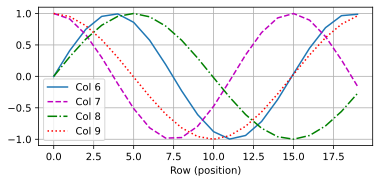

In [43]:
# for this example, set the embedding d to 64 and the length of sequence 20
encoding_dim, num_steps = 64, 20
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
position_1 = 6
position_2 = 10
d2l.plot(torch.arange(num_steps), P[0, :, position_1:position_2].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(position_1, position_2)])

In this diagram, each of these waves will be superimposed across its corresponding positional vector -- e.g. the blue wave will be superimposed on the embedding vector for token position 6.

We can read these values out:

In [44]:
print(P[0, 1, :])
print(P[0, 1, :].shape)

tensor([8.4147e-01, 5.4030e-01, 6.8156e-01, 7.3176e-01, 5.3317e-01, 8.4601e-01,
        4.0931e-01, 9.1240e-01, 3.1098e-01, 9.5042e-01, 2.3492e-01, 9.7201e-01,
        1.7689e-01, 9.8423e-01, 1.3296e-01, 9.9112e-01, 9.9833e-02, 9.9500e-01,
        7.4919e-02, 9.9719e-01, 5.6204e-02, 9.9842e-01, 4.2157e-02, 9.9911e-01,
        3.1618e-02, 9.9950e-01, 2.3712e-02, 9.9972e-01, 1.7782e-02, 9.9984e-01,
        1.3335e-02, 9.9991e-01, 9.9998e-03, 9.9995e-01, 7.4989e-03, 9.9997e-01,
        5.6234e-03, 9.9998e-01, 4.2170e-03, 9.9999e-01, 3.1623e-03, 9.9999e-01,
        2.3714e-03, 1.0000e+00, 1.7783e-03, 1.0000e+00, 1.3335e-03, 1.0000e+00,
        1.0000e-03, 1.0000e+00, 7.4989e-04, 1.0000e+00, 5.6234e-04, 1.0000e+00,
        4.2170e-04, 1.0000e+00, 3.1623e-04, 1.0000e+00, 2.3714e-04, 1.0000e+00,
        1.7783e-04, 1.0000e+00, 1.3335e-04, 1.0000e+00])
torch.Size([64])


Note that we can extend this same sequence to any sequence length, if we wish, or width.

Let's just run it for our canonical examples:

In [45]:
print(queries.shape)
print(embedding_dim)
pos_encoder = PositionalEncoding(embedding_dim, 0)
print(pos_encoder(queries).shape)

torch.Size([2, 6, 768])
768
torch.Size([2, 6, 768])


# Transformer Encoder

## Residual Connections and Normalization

Now, we are finally ready to assemble our complete encoder network.

We can refer to the original diagram:

![](https://d2l.ai/_images/transformer.svg)

By now we have examined the core novel block, namely multi-head attention with positional-encoded superimposition. Now we complete the encoder block with what are essentially standard DL components and architectural arrangements.

We put the outputs through a batch norm with a residual feed-forward connection from the MHA plus a skip connection from the original input to the MHA. This skip method was used in convolutional nets like Resnet:

![](https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png)

It has two purposes that have been shown to work -- i.e. if it works, then we can use it. But from a theoretical point of view, what is the justification?

In networks with depth ("wide" networks), we face the potential issue of vanishing gradients. It happens when we end up in our loss-function space where the partial deriatives w.r.t. weights are very small -- i.e. the gradient is shallow. Combine this with a potentially small learning rate and our weight updates are so small as to drive the network into a stall -- i.e. it stops learning.

By adding in the original input to its functional output, we end up driving backprop through an identity matrix, namely the Vector Jacobians themselves, unaffected by the learning rate. It is a simple way of amplifying the gradients to avoid vanishing. 

Moreover, the second purpose is that by "leaking" the input through to the next layer, that next layer can attend to both the original (previous layer) features and the processed features ("feature map") of the input space. In intuitive terms, this allows the network to access more information wherein patterns can be identified in the interaction of different feature spaces without so limiting the processing to only pay attention to features accessible in the output of the preceding layer.

Just because our DL networks have layers, there is no need to assume that the abstraction into different feature spaces need be confined to layers. Perhaps there are modes of language modeling that can make sense of abstract features, say grammatical tense, __in combination with__ lower level syntactical features -- i.e. language understanding is hierarchical across the various layers of abstraction versus purely functional.

Whilst these intuitions make sense, we should be aware that they don't have to per se. So long as our entire process is differentiable, we can construct any architecture we like if we believe it to be of value. This is the joy of experimenting with frameworks like Pytorch where backprop is taken care of automatically via autograd. keep in mind that researchers will often try many alternatives before finding one that works -- the one that gets reported. We shouldn't receive the report as some kind of well thought-out genius -- it can very well be the result of lots of experimentation, much of it trial and error.

Otherwise, the FFN includes layer normalization [nn.LayerNorm]()



## Final Feed-Forward Network

After computation of the multi-head attention vector and normalization, along with a residual component, the outputs are fed into a final FFN layer -- a 2-layer dense net with 1 hidden layer and 1 output layer.

In the original transformer model, the FFN accounts for [two thirds of the total parameters per block](https://arxiv.org/pdf/2012.14913v1.pdf). Hence it has a lot of "learning power" compared to the attention component, even though the common analysis tends to focus upon the attention component as being the significant feature of a transformer.

How is this layer constructed?

All of the attention vectors are fed to through the same FFN -- i.e. its input dimensions are the same as the embedding dimension, as are its output dimensions. For the inner hidden dimension (number of neurons in layer 1) -- `ffn_num_hiddens`, typically, it is set to be 4 times larger than the embedding dimension `d`, which is also set to be the output size -- `ffn_num_outputs`.

Each input (i.e. token in the sequence) is therefore identically transformed by the FFN weight and bias matrices. We can confirm this:

In [46]:
# here is the FFN declaration
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [47]:
# configure an arbitray example, assuming the following parameters:
output_dimension = 40 # will be same as embedding_dim ordinarily
hidden_width = 10
ffn = PositionWiseFFN(hidden_width, output_dimension)

In [48]:
# feed in a toy example of a single sample in the batch
ffn.eval()
sequence_length = 4
batch_size = 1 # one sample
sample = torch.ones((1, sequence_length, output_dimension))
ffn_output = ffn(sample)
print(f'ffn_output shape: {ffn_output.shape}')

# are the outputs the same?
identical_values = all(ffn_output[0,0,:].detach().numpy() == ffn_output[0,0,:].detach().numpy())
print(f'identical_values (of any two samples): {identical_values}')

ffn_output shape: torch.Size([1, 4, 40])
identical_values (of any two samples): True


In [49]:
ffn

PositionWiseFFN(
  (dense1): Linear(in_features=40, out_features=10, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=10, out_features=40, bias=True)
)

## Position-wise?

The network has the name of position-wise because it transforms __all of the sequence positions__ with the same weights -- i.e. the same operation is performed on each position regardless of position. I guess one could think of this naming approach as inspired by [bitwise operations](https://en.wikipedia.org/wiki/Bitwise_operation) wherein each bit is subject to the same operation (like a logical NOT). In this case, each position in the sequence is subjected to the same operation. I guess this benefits from being pointed out with an explicit name lest we might think it a better idea to treat each position with a separately learned network. Otherwise, the FFN is just a plain vanilla dense network.

__Why does this layer exist?__

The previous MHA component has learnable parameters: `W_Q,W_K,W_V,W_O`. We are expecting the learning capacity of these elements to be with relation to word position and con-joint relationships within the embedding space. The operation of the MHA component is somewhat constrained in that its core modality is weighted-sum "averaging", albeit attendant to different "averaging" expressions that are context related.

Now that we have a set of attention vectors, we need some kind of learning capacity that can attend to how to manipulate these vectors into a manifold(s) constructed within the attention-vector space itself for a far richer hidden representation of language constructs. Indeed, in the paper [Augmenting Self-attention with Persistent Memory](https://arxiv.org/pdf/1907.01470.pdf), the authors make the point:

>the sequence of self-attention and feedforward sublayers, should be
regarded as a single mechanism that gathers information from the context and transforms it into a
rich representation.

The one thing we know about language, especially given how large models have become, is that any attempt at modelling needs a maximally expressive discriminator to attempt to separate all the various and nuanced patterns that make language so complex.

__But what is the FFN doing in relation to the MHA component?__

This is not discussed explicitly in our sources for this analysis, nor in the original transformer paper. But attempts have since been made to "reverse engineer" its contribution to the expressive power of transformers, such as this an paper in which the claim is made: [Transformer Feed-Forward Layers Are Key-Value Memories](https://arxiv.org/pdf/2012.14913v1.pdf).

Unfortunately the paper initially gives the impression that it might be referring to the `k,v` used in self-attention, but it is not. It is referring to the apparent behavior of the FFN as if the first layers activations is a set of keys that excite context-dependent values in the second layer. (Indeed, this insight was discussed in the paper [Augmenting Self-attention with Persistent Memory](https://arxiv.org/pdf/1907.01470.pdf) and is why they ended up removing the FFN and extending the expressiveness of the MHA.)

Each of the hidden-layer outputs can be considered as a memory state. As the paper says: if transformer feed-forward layers are indeed key-value memories, then what memories do they store?

Per the authors:

>We conjecture that each key vector [key] captures
a particular pattern (or set of patterns) in the input
sequence, and that its corresponding
value vector represents the distribution of tokens that follows said pattern.

Consider the diagram from their paper:

![](https://uca57863dab8a2bf3557e96488c3.previews.dropboxusercontent.com/p/thumb/ABukHSPC1icDCBR2FkvDmnvTFe10s4nhSaG0LpXMumxloURuTMTtsv--nlgJrJNd1ZN4Nkct9Hb4hq69jSZyJWDlfU4xOzIQ5BGMl9dCce3bEuivu2nxmBuBVlPwqs4R4QMDQiG8unKIyLwW7Qa5JYWtd-KkYDdKmUCoSeUQsn54Kd0lVS0NT8-PXR9KmrUwNcFPOBEYMo8v2HW6uXfbWSariAeQEihBfUFbajf_PBKG4r0Cg5Jv7n5pFwOg1x04AKJfMybHCPx_llxUmmuc_VmaHPO8QSfiHxDnIgJOj_hxg5D30JCmpoKikSRxBwNEzdWfYRDs-UR3FBUq6ypFRdJI7R1Gb6vRkqSa4_wGkK2e1D2nfjX0_qyyiUlTMI2tf0zYsTVn7-YQb_EY9CQ7brtB/p.png)

In this diagram, the claim is that the activation of `k` corresponds with a pattern related to time wherein the preceding block of text ends with `a` (such as `...it will take a _____`) and that the correspondingly activated value is a distribution centered upon the word `while`.

How did the researchers manage to associate certain word patterns with keys, such as the pattern shown in the figure? They did so by finding the top activating training samples for each key and then asking humans if those training samples presented any discernible pattern. In most cases, humans found several potential patterns. Given this intervention, it was possible to interpret the keys. As it turned out, this was remarkably possible for many of the keys. In a way, this is reassuring in that we can see that the FNN is doing something along the lines we expected and what we discussed above with our examples like:

- `There are many metaphors for thinking about time. For example: time *___* like an arrow.` __(Context A)__
- `Insects are often attracted to fruit. For example, fruit *___* like a banana` __(Context B)__

We hoped that the MHA would understand joint-probability patterns in the data spread across positions and that this would equip our model to identify overlaying distributions of patterns. This is indeed what the FFN appears to be doing. We can think of the MHA as being a learnable discriminator of possible patterns and the FFN as a learnable classifier of those patterns tied to distributions of words that are likely to be associated with each pattern class.



# Encoder Block

Now that we have visited all the components of the encoder, we can tie them together into a single class declaration in readiness for instantion in a trainable model.

## Residual Connections

We first declare our residual connection module:

In [50]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

Note that the residual "short-circuit" or "skip connection" element-wise addition requires that the two inputs are of the same shape: `(self.dropout(Y) + X)` and hence the output tensor will also have the same shape after the addition operation.

The layer is otherwise standard in terms of configuring an [nn.LayerNorm]() component (with some dropout for regularization) and a matrix addition to fold in the original input term.

This residual method is to prevent degradation of network performance (accuracy) as we stack layers. It is a method introduced via the ["ResNet" paper](https://arxiv.org/pdf/1512.03385v1.pdf) wherein they demonstrated emperically that the short circuit method provided resilience to degradation over depth. They did not present any theoretical justification, but this reinforces my introductory remarks that experimentation is often a very productive method of getting results with DL. So, do not be afraid to experiment!

Some theoretical studies have been put forward, such as [Why Do Deep Residual Networks Generalize Better
than Deep Feedforward Networks? — A Neural
Tangent Kernel Perspective](https://arxiv.org/pdf/2002.06262.pdf) -- but we need not concern ourselves with this level of theoretical analysis, as indeed the inventors of the transformer didn't.

## Encoder Class

Now we have all of the components necessary to declare an encoder class:

In [51]:
class TransformerEncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [52]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
example_encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
example_encoder_blk.eval()
d2l.check_shape(example_encoder_blk(X, valid_lens), X.shape)

In [53]:
example_encoder_blk

TransformerEncoderBlock(
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
  )
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=24, out_features=48, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=48, out_features=24, bias=True)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
  )
)

Returning to our original queries:

In [54]:
encoder_blk = TransformerEncoderBlock(embedding_dim, 4*embedding_dim, 8, 0.5)
valid_lens = torch.tensor([2,6])

In [55]:
encoder_blk(queries, valid_lens).shape

torch.Size([2, 6, 768])

As expected, the shape of final output concurs with the shape of the original input.

# Reflections

Let's just reflect upon where we have arrived, so that we have a reinforced mental model of the process before proceeding to Part 2 where we shall consider the decoder and possible training approaches.

Our encoder can process `seq_length` (6 in our running example) tokens in parallel in batches of `batch_size` (2 sequences) with the core arithmetic taking place in a space of `embedding_dim` dimensions (768).

Only during the multi-head attention are the tokens interacting, as in the scaled dot product (SDP) that is producing a scalar value for each of the tokens (queries) indicating how much attention to pay to this token within its sequence context (keys/values). The actual MHA arithmetic takes place in a reduced-dimensionality space (`embedding_dim/num_heads`) in order to reduce computational overhead. The outputs are normalized via a softmax layer (that is masked to remove noisy data from padding tokens) to produce a distribution resembling a probability distribution.

The MHA scales quadratically -- i.e. in relation to `seq_length**2`.

We haven't said anything about how the MHA is actually weighted, other than we have described a learnable look-up memory system that can be trained to learn a particular attention pattern per head. We have described intuitions that allow us to believe that relative positional encoding alongside word embeddings will provide a rich-enough input vector space to allow meaningful syntactical and semantic attention features to be learned at scale, meaning across lots of examples with reasonable sequence lengths (e.g. 512 in the case of Bert, say).

We have not said anything yet about stacking of encoder modules, other than our architecture includes residual (short-circuit) feeds whose role is to prevent degeneration of performance with depth. As it turns out, researchers have concluded that the key determining factor in model performance is depth.

Although the MHA appears to be the core component with the FFN playing "second fiddle", we have noticed a substantial amount of learning potential is situated in the wieghts of the position-wise FFN. Researchers have shown (in papers we alluded to) that the Transformer encoder needs to be thought of as a single combined unit of MHA and FFN working in tandem. Indeed, the FFN appears to be like a key-value memory extension of the MHA, a realization that motivated some researchers to replace the FFN with an "extended" MHA component.

It is useful to realize that we have not yet said how this encoder could be trained, but we know that it is set up to allow unsupervised autoregressive training by observation of text sequences. In the case of Bert, the training task involves randomly masking words in the sequences and asking the encoder to predict the masked words. Concurrently, the encoder is asked to predict whether one sentence follows another -- i.e. next-sentence prediction.

Part 2 will be published soon.

# Teaser: What Attention "Looks Like"

Prior to exploring how training works in Part 2, let's just get a sneak-peek at what a trained attention mechanism might look like. If you have the libs below, you can run the code to play with the impressive bertviz tool for visualizing attention vectors over multiple heads at each layer.

In the screenshots below, I have included focus only on the word `man` in the first sentence, activating all of the heads (the colored bands) for the first three layers.

In [59]:
# from bertviz import head_view
# from transformers import AutoModel

# model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

# sentence_a = "The man did it, said the boy."
# sentence_b = "The man said the boy did it."

# viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
# attention = model(**viz_inputs).attentions
# sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
# tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

# head_view(attention, tokens, sentence_b_start, heads=[8])

## Layer 0 Attention -- "boot-strapping"

Here we can see that `man` has attention from all other words. This is not surprising, given those words. We can see obvious examples where the attention is strong, such as the word `the` -- we expect that the bi-gram `the man` is going to be common in our corpus.

But we can also see in one of the heads (second from right of the vertical colored bars) that the word `did` is paying more attention than any others. We might posit that we expect at least one attention pattern to relate subjects `man` with predicates `did`. Remember, the network doesn't understand language. It is looking for statistical (probabilistic) patterns as this is the only mechanism available to the network -- i.e. the only thing it can "observe" about the tokens.

This is the first, or "bootstrap", layer and so we might expect a lot of many-to-many relationships via attention because words like `man` and `boy` could have all kinds of semantic and syntactical co-occurences. Indeed, if we look at the `boy` horizontal color bar (i.e. across all heads), we see some degree of attention.


![layer0](https://uc5309055ec940730be9f7b899a6.previews.dropboxusercontent.com/p/thumb/ABs07lS5-Zpz7NgfYpj5zg2wgpA8oSguCN5XQ6aVx0tr6YTHrvRa82plOLY5sHy9PhY3KztjBCfftAfmsZm2Iu-0Mnl7RSABARNg7OUs_hzITuLVx7i-jNy93u99_QU3Ud23_zLVzDQNbr392BlmS2svn5s5jzxiVjo0Eh1Ii7AE0RT3MJlyTGoeOsw7pilMCJVScE7C1NDBvs2dErDhuFJ7Msv_ubIIQCx54s4ks5bqftZZRK-vE1Vo986JBVqUHBcRojpYl972OI5bVIf2FTE_f6CGayy7c-g-NozPbk7bPwcM7SxpgiW1j1Ke_HPkNo7ZsMmjoHKgSFDHelJpcqhu_NaGXgW9uxJAbNfOMOxKtDG8-G_gbX0-2oAT2wlkFCZhokyjxFo5HBvxcxzSA18T/p.png)

## Deeper Understanding -- Layer 2

Here we see a different attention pattern to layer 0. Well, this is encouraging as it shows that deeper layers are at least doing something different to the bootstrap layer, which is what our intuitions would tell us -- i.e. deeper layers have the potential to find "higher abstraction" attention relationships.

What do we notice?

Indeed, the first head is showing a strong attention signal between `man` and `did` as if the network has progressed from a contingent relationship to a more certain one. It has also de-emphasized the potential attention from the word `said` (realizing that `man said` is likely a common bi-gram in the corpus), most likely because attention from `said` has shifted to `[the] boy`.

At this point, we should avoid trying to interpret a definitive "understanding" of the sentence on behalf of the encoder network. It is important to realize that the network has a set of probabilistic arrangements spread across its layers and heads. The actual output -- i.e. a particular "understanding" (or probabilistic distribution over the sequence) will depend upon how use the encoder (and decoder).

For example, if we imagine a question-answering situation, then an additional prompt (input sequence) like `Who did it?` might activate the highest likelihood to be placed upon the sequence `the man did it` versus other possibilities within this text, like `the boy did it` (those words are contained within this set of words).


![layer2](https://ucea0854ee0e78dd1f50708d06b1.previews.dropboxusercontent.com/p/thumb/ABtCkseJ4YsO3MgKH2MgSaftBdC2byEybU94MXfW-5zHnGgReGYOV_eCHlakZFmBkLvO0nf7mhdkkMDEH9fBmn1iIevJLouT2MAk_QDJLrK6kdX_d8mIymh2YpF-KW68PSsziiNU1fcdMXxH_maWQ5dK9LWyfRtir94moywFkKYl8h5I2n8HIcKmeTU3zJ_KhpCq6QdhvXXGjXhP9Ipf5QSehLG0MhFC6JAGS17H_8iQ3Dz0_l-H8QPaWlfBJ68YUuJriONCg-_H-d274XSZoIoX7tx6CA2z7HlYe0OgjZO8rvdfDY9SCTkvR6m-G40L63R9CDursvhSTDh_tJEiu5BaJMU-kvtndRoJEwHC1NR3j7W7WvpzSOmC42eIrl3P-yav7pSiD7270ohWv9c9o82b/p.png)

## The Curious [CLS] Token

We have not yet discussed training and how text it tokenized, apart from earlier mention of the padding token. We see here two new tokens: `[CLS]` and `[SEP]` to indicate the start and end of a sequence.

We -- as in human observers -- do not assign any meaning to the `[CLS]` token, yet the attention mechanism is clearly assigning some attention. After all, the token does have a numerical representation in the embedding space and so will get incorporated into the MHA scaled dot product arithmetic.

This turns out to be useful as we can think of the `[CLS]` token as a neutral "placeholder" whose attention value is going to somehow incorporate attention from all of the other tokens. As such, we can think of it as a kind of "summary" token into which is folded a "reflection" of the attention generated by the text sequence. This output can be used for tasks like classification -- e.g. when trying to add a classifier network to learn things like sentiment or emotional content, we can feed the output from the `[CLS]` token into the classifier. It turns out this is a useful approach.

![layer1](https://uc09c6e89ec6b2992b99fa061037.previews.dropboxusercontent.com/p/thumb/ABuk1aSsIJVDFqMXKtUXy4HS_I2HzWuj4XQhy1GP148mNt2eqQf_OnFNVaqjZrgbpZSDtjk3pymc3_f4Y1bnfRTFtrv8ynaXMB9XceVgfz2w35sb_JwwCs95Wy8vcfS1vw28f1PTXUZwAawB7M1KPorEzvibaMDupcznE_VOR8qWu6Q7hl-LFt5y2ljqWsCAK6DR_es_L8rfxtczLxHFZll38KUFBncpcXdnLcf_yIyuECpbIfALGyv-3rfOY4VWwzAJwFqyglLEyMDLUAzInERKMTPtghAIOmbgqQcKyskQ8_V-xVvL1ZRf_4B_SGnwRvC3JYCcwLPF0LrxCBCWjTmvoEG_DreY9x0w91p54JY4fSagn8VPQKMiqz2VDEmWrh-KMwAAzAQA7jdAPx1IKd9K/p.png)